# Distracted Driver Detection
Capstone


# 图像分类

在该项目中，我将会对来自走神司机数据集(https://www.kaggle.com/c/state-farm-distracted-driver-detection/data) 中的图像进行分类。数据集中图片的内容包括司机的10中状态。我需要处理这些图像，训练一个卷积神经网络对他们进行分类。

## 观察数据，准备读取

引入必需的库，读取图片函数。大致观察训练数据。

### 导入需要使用的库
包括基于tensorflow的keras，OpenCV，numpy，pandas，sklearn等。

In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow'
import keras

Using TensorFlow backend.


In [2]:
import numpy as np
np.random.seed(2017)

import os
import glob
import cv2
import math
import pickle
import pandas as pd
import random
from tqdm import tqdm
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD, Adam, Nadam
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.metrics import log_loss

### 解压缩imgs.zip文件夹，获取train和test图片。
仅在第一次运行时需要。

In [3]:
import zipfile, os
z = zipfile.ZipFile('imgs.zip')
z.extractall()
z.close()

### 图片读取函数
针对Xception模型进行图片读取和预处理。具体而言，使用OpenCV库从路径获取图片，尺寸改变为299*299*3。通道转换为RGB顺序。像素归一化。

In [3]:
# Load a preprocessed image
def get_im_cv2(path, img_size):
    img = cv2.imread(path)
    img = np.array(img, dtype=np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # reduce size
    img = cv2.resize(img, (img_size, img_size))
    # normalization
    img /= 127.5
    img -= 1.
    #print (img[1:5, 1:5, 0])
    return img

### 图片读取函数，附加实时增强
针对Xception模型进行图片读取和预处理。具体而言，使用OpenCV库从路径获取图片。然后进行图片增强处理，绕图片中心点随机旋转-10到10度，并在横向上平移-50到50个pixel。这个范围是观察一些图片后，根据不同图片之间拍摄的角度和位置差异，决定在这个范围内做随机增强。目的是加强模型的泛化能力，防止过拟合。
和上一个函数一样，也针对Xception模型进行预处理。尺寸改变为299*299*3。通道转换为RGB顺序。像素归一化。

In [4]:
from keras.preprocessing import image

# image rotation
def rotate(x, degree, row_axis=0, col_axis=1, channel_axis=2, fill_mode='wrap', cval=0.):
    theta = np.pi / 180 * degree
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta), np.cos(theta), 0],
    [0, 0, 1]])
    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = image.transform_matrix_offset_center(rotation_matrix, h, w)
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

# image shift
def shift(x, wshift, hshift, row_axis=0, col_axis=1, channel_axis=2, fill_mode='wrap', cval=0.):
    h, w = x.shape[row_axis], x.shape[col_axis] #读取图片的高和宽
    tx = hshift * h #高偏移大小，若不偏移可设为0，若向上偏移设为正数
    ty = wshift * w #宽偏移大小，若不偏移可设为0，若向左偏移设为正数
    translation_matrix = np.array([[1, 0, tx],
                                  [0, 1, ty],
                                  [0, 0, 1]])
    transform_matrix = translation_matrix  
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

# PCA
def RGB_PCA(images):
    pixels = images.reshape(-1, images.shape[-1])
    m = np.mean(pixels, axis=0)
    pixels -= m
    C = np.cov(pixels, rowvar=False)
    l, v = np.linalg.eig(C)
    idx = np.argsort(l)[::-1]
    v = v[:,idx]
    l = l[idx]
    #print (C.shape, len(l), len(v))
    return l, v
def RGB_variations(image, eig_val, eig_vec):
    a = 0.1 * np.random.randn(3)
    v = np.array([a[0]*eig_val[0], a[1]*eig_val[1], a[2]*eig_val[2]])
    variation = np.dot(eig_vec, v)
    return image + variation

# change HSV
def randomHueSaturationValue(image, hue_shift_limit=(-10, 10),
                            sat_shift_limit=(-75, 75),
                            val_shift_limit=(-75, 75), u=0.5):
    if np.random.random() < u:
        img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s ,v = img[:,:,0],img[:,:,1],img[:,:,2]
        hue_shift = np.random.uniform(hue_shift_limit[0], hue_shift_limit[1])
        h = h + hue_shift

        sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
        s = s + sat_shift

        val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
        v = v + val_shift

        img[:,:,0],img[:,:,1],img[:,:,2] = h, s ,v
        image = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)

    return image


In [5]:
# Load a random augmented image
def get_im_cv2_aug(path, img_size):
    img = cv2.imread(path)
    img = np.array(img, dtype=np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #random rotate
    
    deg = random.uniform(-10, 10) #random rotate limit
    img = rotate(img, deg)
    
    #random shift
    wshift = random.uniform(-0.1, 0.1)
    hshift = random.uniform(-0.1, 0.1)
    img = shift(img, wshift, hshift)
    
    # change HSV
    #img = randomHueSaturationValue(img)
    
    # PCA
    #img = img/255.0
    #l, v = RGB_PCA(img)
    #img = RGB_variations(img, l, v)
    #img = img * 255.0
    
    # reduce size
    img = cv2.resize(img, (img_size, img_size))
    
    # normalization
    
    img /= 127.5
    img -= 1.

    return img

### 展示样例图片，并大致观察一下数据的分布。
展示的这张图片是经过实时增强的，色彩经过减均值后有些变化。 经过大致的对10类train 图片的观察，发现有些图片给出的分类是有问题的。比如p081号司机几乎在所有类别里都是把脸转向副驾驶角度，因此把不包括p081司机的数据集，作为下面训练的train和validation图片来源。里面的图片数量从原来的22424张减少到了21601张

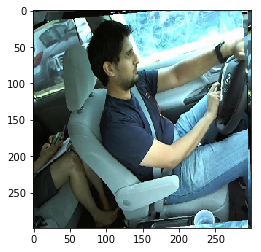

In [12]:
%matplotlib inline
path = os.path.join('.', 'train', 'c0', 'img_1078.jpg')

plt.imshow((get_im_cv2_aug(path, 299)+1)/2)

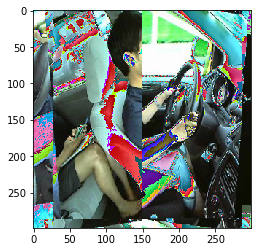

In [14]:
path1 = os.path.join('.', 'train', 'c0', 'img_1078.jpg')
img = get_im_cv2_aug(path1, 299)
if random.random()>0.5:
    path2 = os.path.join('.', 'train', 'c0', 'img_327.jpg')
    img2 = get_im_cv2_aug(path2, 299)
    left = img[:, :150, :]
    right = img2[:, 150:, :]
    img = np.concatenate((left, right), axis=1)
%matplotlib inline
plt.imshow(img)

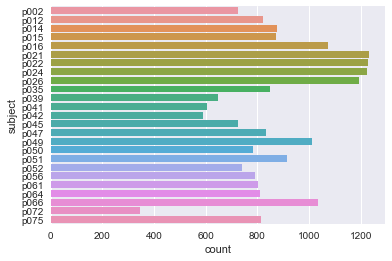

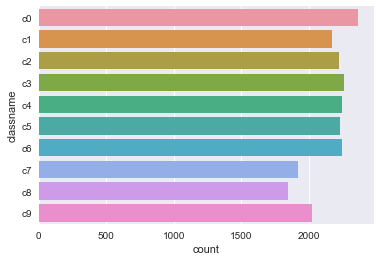

In [15]:
import seaborn as sns
sns.set(style="darkgrid")
drivers = pd.read_csv(os.path.join('.', 'driver_imgs_list_right.csv'))
#print(drivers['classname'][1])

plt.figure(1)
ax1 = sns.countplot(y="subject", data=drivers)

plt.figure(2)
ax2 = sns.countplot(y="classname", data=drivers)

## 迁移学习

迁移学习方法，在预训练模型Xception后面挂自己写的分类器，训练这个分类器和之前的一些层。

以下是具体过程：

### 切分数据

按照司机的id来切分训练数据集。把driver_imgs_list分成两个列表。一个是训练列表，里面是所有训练集司机的图片文件名。另一个是验证列表，里面是所有验证集司机的图片文件名。然后把两个列表都随机打乱。 这里列表里面保存的都只是excel文件里的一行行数据（包括文件名，分类，司机id），而不是图片本身。等训练时通过生成器读取图片，这样节约内存。 另外还保存了一个类别字典，便于以后从同一类中抽取图片进行拼接。

In [6]:
# divide drivers
unique_list_train = ['p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075']
unique_list_valid = ['p002', 'p012', 'p014', 'p015']
#print (unique_list_train, unique_list_valid)

# get index: driver_id, class, image name
index = os.path.join('.', 'driver_imgs_list.csv')

# build the driver id dictionary and class dictionary
f = open(index, 'r')
id_dict = dict()
class_dict = dict()
lines = f.readlines()
for line in lines[1:]:
    arr = line.strip().split(',')
    if arr[0] not in id_dict.keys():
        id_dict[arr[0]] = [line]
    else:
        id_dict[arr[0]].append(line)
    if arr[1] not in class_dict.keys():
        class_dict[arr[1]] = [line]
    else:
        class_dict[arr[1]].append(line)
f.close()

# split the train list and valid list by id
train_list = []
valid_list = []
for id in id_dict.keys():
    if id in unique_list_train:
        train_list.extend(id_dict[id])
    elif id in unique_list_valid:
        valid_list.extend(id_dict[id])
random.shuffle(train_list)
random.shuffle(valid_list)

print (len(train_list), len(valid_list))

18302 3299


### 获取test set图片的列表
获取sample_submission.csv中所有测试图片的文件名，预测test set时使用。

In [7]:
test_index = os.path.join('.', 'sample_submission.csv')
f = open(test_index, 'r')
lines = f.readlines()
test_list = []
for line in lines[1:]:
    arr = line.strip().split(',')
    test_list.append(arr[0])
f.close()
print (test_list[:5])

['img_1.jpg', 'img_10.jpg', 'img_100.jpg', 'img_1000.jpg', 'img_100000.jpg']


### 转换为One Hot Encode标签

对分类标签进行One Hot Encode的函数如下。

In [8]:
# one hot encode the class label

from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])   
def one_hot_encode(x):
    return lb.transform(x)
t = one_hot_encode(['c1', 'c2'])
print(t)

[[0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]]


### 训练图片生成器

从训练列表中遍历。yield一个batch的训练图片及其标签。图片经过了实时增强。另外还有50%的概率随机选取另一张同类里的图片，将两张的左右各半边拼接在一起。这也是为了训练模型对分类的关键部位进行学习，而不是记住司机的样子

In [9]:
# define my train data generator
def train_gen(batch_size):
    #random.shuffle(train_list) # 每一代都随机shuffle训练集
    current = 0
    while 1:
        x = []
        y = []
        while len(y) < batch_size:
            line = train_list[current]
            arr = line.strip().split(',')
            path1 = os.path.join('.', 'train', str(arr[1]), str(arr[2]))
            img = get_im_cv2_aug(path1, 299)
            if random.random()>0.5:
                line2 = random.choice(class_dict[arr[1]])
                bname = line2.strip().split(',')[2]
                path2 = os.path.join('.', 'train', str(arr[1]), str(bname))
                img2 = get_im_cv2_aug(path2, 299)
                left = img[:, :150, :]
                right = img2[:, 150:, :]
                img = np.concatenate((left, right), axis=1)
            x.append(img)
            label = one_hot_encode([str(arr[1])])[0]
            y.append(label)
            current += 1
            if current >= len(train_list):
                current = 0
        x = np.array(x)
        x = x.reshape(batch_size, img_size, img_size, 3) 
        y = np.array(y, dtype = np.uint8)
        y = y.reshape(batch_size, 10)

        yield (x, y)

### 验证图片生成器

从验证列表中遍历。yield一个batch的验证图片及其标签。为了体现模型训练后的拟合能力，图片没有进行实时增强。

In [10]:
# define my validation data generator

def valid_gen(batch_size):
    current = 0
    while 1:
        x = []
        y = []
        while len(y) < batch_size:
            line = valid_list[current]
            arr = line.strip().split(',')
            path = os.path.join('.', 'train', str(arr[1]), str(arr[2]))
            #print (path)
            img = get_im_cv2(path, 299)
            x.append(img)
            label = one_hot_encode([str(arr[1])])[0]
            y.append(label)
            current += 1
            if current >= len(valid_list):
                current = 0
        x = np.array(x)
        x = x.reshape(batch_size, img_size, img_size, 3) 
        y = np.array(y, dtype = np.uint8)
        y = y.reshape(batch_size, 10)
        yield (x, y)

### 构建模型

用keras构建模型。使用在ImageNet上预训练好的Xception模型，接上一个global average pooling层，dropout防止过拟合，最后一个全连接层输出10个类别的概率。在全连接层的权重上采用了L2正则化。锁定模型的前80层不更新权重.

In [22]:
from keras import backend as K
K.clear_session()

In [23]:
# new model

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

img_size = 299
x = Input((img_size, img_size, 3))
base_model = Xception(input_tensor = x, weights='imagenet', include_top=False)


x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)
model = Model(base_model.input, x)

for i in range(80):
    model.layers[i].trainable = False
    
model.summary()
len(model.layers)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

135

### 训练
进行模型训练。这里batch size为64。用了自适应优化器Nadam，使用schedule learning rate自动调整学习率的方法并在验证loss不下降时early stopping。一共训练4代。steps per epoch设定为在一个epoch内所有训练图片被遍历1次.

In [24]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
model.compile(optimizer=Nadam(),loss='categorical_crossentropy',metrics=['categorical_accuracy'])

def learning_rate(epoch):
    ini_lr = 0.002
    lr = ini_lr * pow(10, -epoch)
    return lr

cp = ModelCheckpoint(filepath="my_model11.h5", save_best_only=True)
es = EarlyStopping()
lrs = LearningRateScheduler(learning_rate)
hist = model.fit_generator(train_gen(64), steps_per_epoch = 286, epochs = 5, workers=8, max_q_size=40, use_multiprocessing=True, validation_data = valid_gen(64), validation_steps = 52, callbacks=[cp, es, lrs])

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=286, epochs=5, workers=8, use_multiprocessing=True, validation_data=<generator..., validation_steps=52, callbacks=[<keras.ca..., max_queue_size=40)`
  if sys.path[0] == '':
/home/ubuntu/anaconda/lib/python3.6/site-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
286/286 [==============================] - 2115s 7s/step - loss: 0.2161 - categorical_accuracy: 0.9606 - val_loss: 0.6827 - val_categorical_accuracy: 0.7849
Epoch 2/5
286/286 [==============================] - 1990s 7s/step - loss: 0.0899 - categorical_accuracy: 0.9860 - val_loss: 0.4621 - val_categorical_accuracy: 0.8588
Epoch 3/5
286/286 [==============================] - 1990s 7s/step - loss: 0.0786 - categorical_accuracy: 0.9866 - val_loss: 0.3455 - val_categorical_accuracy: 0.9044
Epoch 4/5
286/286 [==============================] - 1984s 7s/step - loss: 0.0880 - categorical_accuracy: 0.9853 - val_loss: 0.4345 - val_categorical_accuracy: 0.8693


### 模型结果

保存模型。输出history数据，观察loss曲线。 这里忘记设置inline，没有显示曲线。从数据来看验证集loss明显降低，分类精度提高。

### 对测试集进行预测

载入模型。对test数据进行预测，将结果写入csv文件。这里使用了keras自带的图片生成器。

In [9]:
# load the model 载入已经训练好的模型！！！
from keras.models import load_model  
model = load_model('my_model11.h5')

In [25]:
# define my test data generator
from keras.preprocessing.image import *
from keras.applications.xception import preprocess_input

test_index = os.path.join('.', 'test')
gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = gen.flow_from_directory(test_index, target_size=(299,299), shuffle=False, batch_size=64, class_mode=None)


Found 79726 images belonging to 1 classes.


In [26]:

y_pred = model.predict_generator(test_gen, steps=test_gen.samples//64+1)

In [27]:
test_id = []
for f in test_gen.filenames:
    test_id.append(f)
    
result = pd.DataFrame(y_pred, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
result.insert(0, 'img', pd.Series(test_id, index=result.index))
result.to_csv(os.path.join('.' ,'my_submission11.csv'), index=False)

### 模型成绩
提交kaggle成绩：public score 0.34 private score 0.35